In [2]:
application = 'Innovation_Vineyards'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [5]:
import pathlib

In [6]:
from matplotlib import pyplot as plt

In [7]:
import geopandas as gpd
import regionmask

In [8]:
import numpy as np 
import pandas as pd
import xarray as xr

In [9]:
HOME = pathlib.Path.home()

In [10]:
root_path = HOME.joinpath(f'research/Smart_Ideas/data/shapefiles/application_cases/{application}') 

In [11]:
shapes = gpd.read_file(root_path.joinpath('Innovationvineyardpolygon-polygon.shp'))

### check the CRS 

In [12]:
shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### convert to CRS 4242 (NZGD49)

In [13]:
shapes = shapes.to_crs('epsg:4272')

In [14]:
shapes.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

<AxesSubplot:>

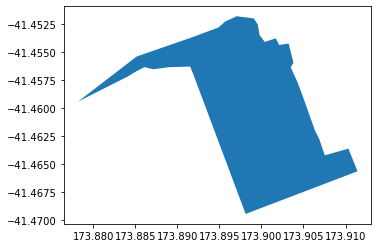

In [15]:
shapes.plot()

### get the bounds 

In [16]:
bounds = shapes.bounds

In [17]:
bounds 

,minx,miny,maxx,maxy
0,173.878192,-41.46944,173.911424,-41.451824


In [18]:
minx, maxx = bounds.minx.min(), bounds.maxx.max()

In [19]:
miny, maxy = bounds.miny.min(), bounds.maxy.max()

### get the coordinates of the bounds 

In [20]:
coords = [minx, maxx, miny, maxy]

In [21]:
coords

[173.878192211887, 173.9114240955932, -41.46943959549427, -41.4518241127478]

In [22]:
d = {}
d['lonmin'] = coords[0]
d['lonmax'] = coords[1]
d['latmin'] = coords[2]
d['latmax'] = coords[3]

In [23]:
xr.Dataset(d)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    lonmin   float64 173.9
    lonmax   float64 173.9
    latmin   float64 -41.47
    latmax   float64 -41.45

### casts into a Dataset then saves to disk 

In [24]:
dset = xr.Dataset(d)

In [25]:
dset.to_netcdf(root_path.joinpath('Innovation_Vineyard_bounding_box.nc'))

### plots with basemap 

#### convert the CRS to Web Mercator 

In [26]:
df = shapes.to_crs(epsg=3857)

### plot with a basemap (using contextily)

In [27]:
import contextily as ctx

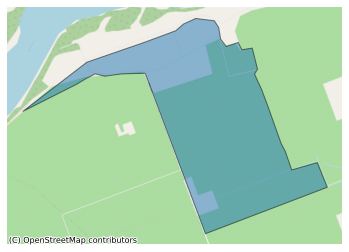

In [28]:
f, ax = plt.subplots(figsize=(6,10))
df.plot(alpha=0.5, edgecolor='k',ax=ax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
f.savefig('./basemap_plot_contextily.png', dpi=200, bbox_inches='tight')

### now read the VCSN DAILY values, and extract time-series 

In [29]:
dpath_vcsn = pathlib.Path('/home/nicolasf/operational/VCSN/data/NC/DAILY') 

### creates the dictionnary mapping variables (names in the file) to variables (name in the dataset )

In [30]:
variables_list = ['TMEAN_N', 'TMIN_N', 'TMAX_N', 'RAIN_BC', 'SOILM', 'RAD']

In [31]:
varnames_list  = ['Tmean_N', 'Tmin_N', 'Tmax_N', 'Rain_bc', 'SoilM', 'Rad']

In [32]:
var_dict = dict(zip(variables_list, varnames_list))

In [33]:
var_dict

{'TMEAN_N': 'Tmean_N',
 'TMIN_N': 'Tmin_N',
 'TMAX_N': 'Tmax_N',
 'RAIN_BC': 'Rain_bc',
 'SOILM': 'SoilM',
 'RAD': 'Rad'}

### loop over the variables, extract and saves to disk the DAILY raw values 

In [34]:
for varname in variables_list: 
    
    print(f"extracting and processing {varname}")
    
    ### get the list of files 
    lfiles = list(dpath_vcsn.joinpath(varname).glob("VCSN_gridded_daily*_????-??.nc"))
    lfiles.sort()
    
    ### read 
    vcsn_dset = xr.open_mfdataset(lfiles, concat_dim='time', parallel=True)
    
    ### define the region 
    #     region_definition = regionmask.from_geopandas(shapes)
    
    ### select the point (centroid of the region)
    point = vcsn_dset.sel(lat = float(shapes.centroid.y), lon=float(shapes.centroid.x), method='nearest')
    
    ### casts into a DataFrame 
    df = point[var_dict[varname]].load().to_dataframe() 
    
    ### saves to disk 
    opath = HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/{varname}") 
    
    if not(opath.exists()): 
        opath.mkdir(parents=True)
        
    df.to_csv(opath.joinpath(f"Daily_{varname}.csv"))
    
    vcsn_dset.close() 
    
    point.close() 

extracting and processing TMEAN_N
extracting and processing TMIN_N
extracting and processing TMAX_N
extracting and processing RAIN_BC
extracting and processing SOILM
extracting and processing RAD
